# Lab Book 5

## Fast Fourier Transform

### Question 1
Write a function which creates the Fourier transform matrix $F_n$ (for any input $n$, not necessarily a power of 2). For $n = 10$, use suitable norms to verify that $F_n$ is symmetric and that $F_n\overline{F}_n = nI$.

Since the DFT is linear, we can write is a matrix transformation from $\mathbb{C}^n \to \mathbb{C}^n$. We define 
$$ \begin{align*} [F_n]_{j,k} &= \omega_n^{jk} & &\forall j,k=0,...,n-1 \end{align*}$$
where $\omega_n = e^{-2\pi i /n}$.

In [431]:
import numpy as np
import math

def fourier_matrix(n):
    # instantiate two arrays
    j, k = np.meshgrid(np.arange(n, dtype=complex), np.arange(n, dtype=complex))
    # calculate omega using python complex arithmetic
    omega = np.exp((-2 * math.pi * 1j) / n)
    # raise omega to the corresponding powers of jk
    W = np.power(omega, j*k)
    return W

We'll generate $F_5$, and check that it's symmetric i.e. $F_5^T=F_5$ by calculating the norms of both matrices.

In [432]:
n = 5
F_5 = fourier_matrix(n)
F_5_T = np.transpose(F_5)
np.allclose(np.linalg.norm(F_5), np.linalg.norm(F_5_T))

True

We also check that the matrix multiplied by its own conjugate is equal to $n$ times the identity matrix:

In [433]:
F_5_bar = np.conjugate(F_5)
result = F_5 @ F_5_bar
np.allclose(np.linalg.norm(result), n*np.linalg.norm(np.eye(n)))

True

### Question 2
For $n = 1, 2, 4, 8, 16, ..., 8192$ (or less if it takes too long), plot the runtime of (a) building the matrix $F_n$ using your code above; (b) calculating the DFT of $\mathbf{x} = (1, 2, 3, . . . , n)^T$ using matrix-vector multiplication (not including creating the matrix $F_n$); and (c) calculating the same DFT using NumPy’s FFT function. Discuss whether your results match the expected results from theory.

In [434]:
import time

sizes = [2**n for n in range(14)]
build_matrix, calculate_dft, numpy_fft = [], [], []
for n in sizes:
    # build matrix 
    start = time.time()
    F = fourier_matrix(n)
    end = time.time()
    build_matrix.append(end-start)
    
    # calculate DFT
    x = np.arange(n) # build vector
    start = time.time()
    x_hat = F @ x # matrix-vector multiplication
    end = time.time()
    calculate_dft.append(end-start)
    
    # calculate using numpy fft
    start = time.time()
    x_hat_np = np.fft.fft(x)
    end = time.time()
    numpy_fft.append(end-start)

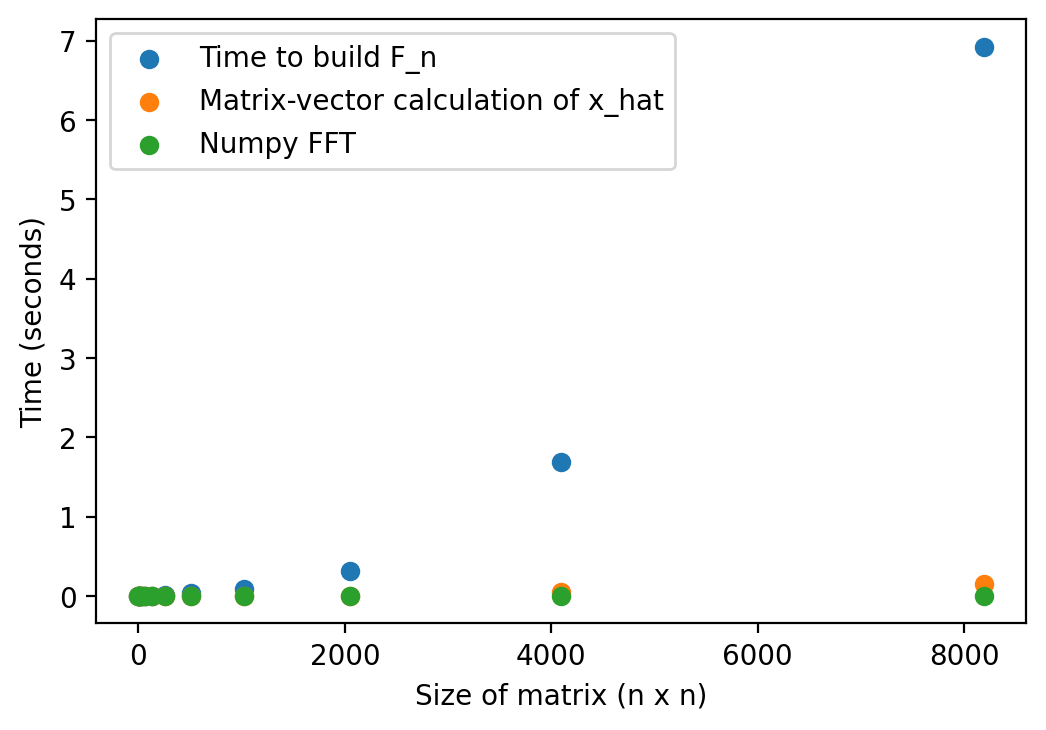

In [435]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

plt.scatter(sizes, build_matrix, label="Time to build F_n")
plt.scatter(sizes, calculate_dft, label="Matrix-vector calculation of x_hat")
plt.scatter(sizes, numpy_fft, label="Numpy FFT")
plt.legend(loc="best")
plt.xlabel("Size of matrix (n x n)")
plt.ylabel("Time (seconds)")
plt.show()

### Question 3
Looking at your plots, pick a magnitude which is slightly larger than the typical ‘noise’
contribution, but much smaller than the size of any spikes. Modify the DFT of `noisy_data` by setting to zero all entries with magnitude less than your chosen level, and calculate the inverse DFT to produce a ‘denoised’ signal (you will have to look up how to calculate an inverse DFT in NumPy). Produce a plot of the original signal, noisy signal and your denoised signal and check that you have removed a reasonable amount of the noise. Quantitatively compare the error (versus data) of the noisy and your denoised signal using suitable norms, to check that your denoised signal is closer to the true data than `noisy_data`.

In [436]:
data = np.loadtxt("lab5_piano_data.csv", delimiter=',')
time = np.linspace(0.0, 1.0, len(data)) # data represents one second of audio
print("CSV has a vector of size =", data.shape[0])

CSV has a vector of size = 44100


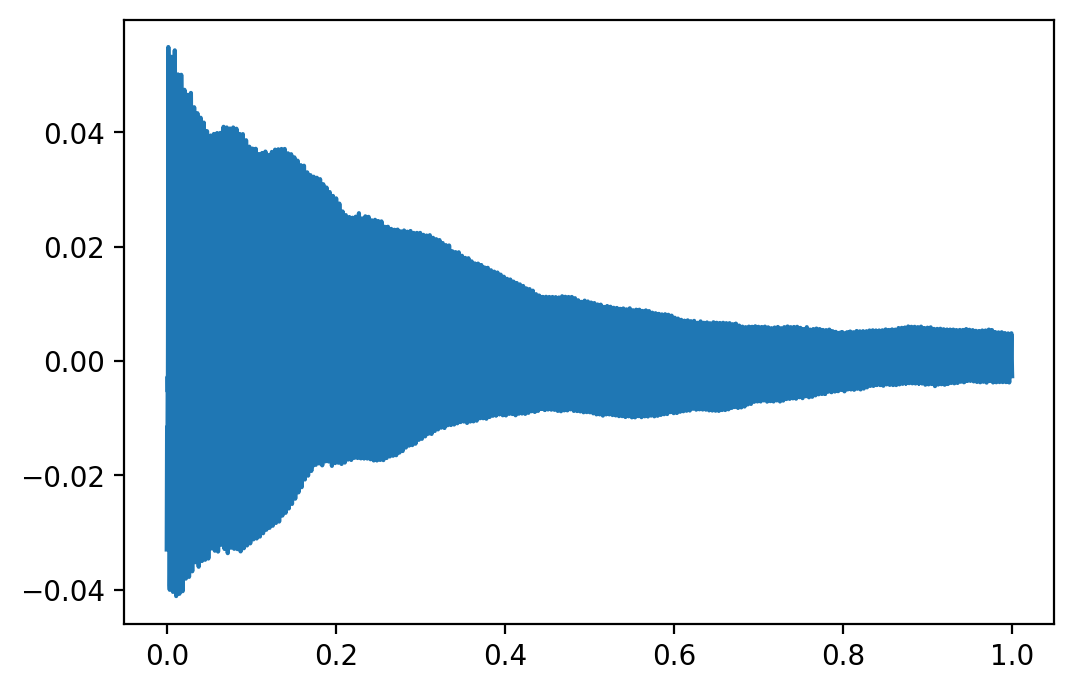

In [437]:
plt.plot(time, data)
plt.show()

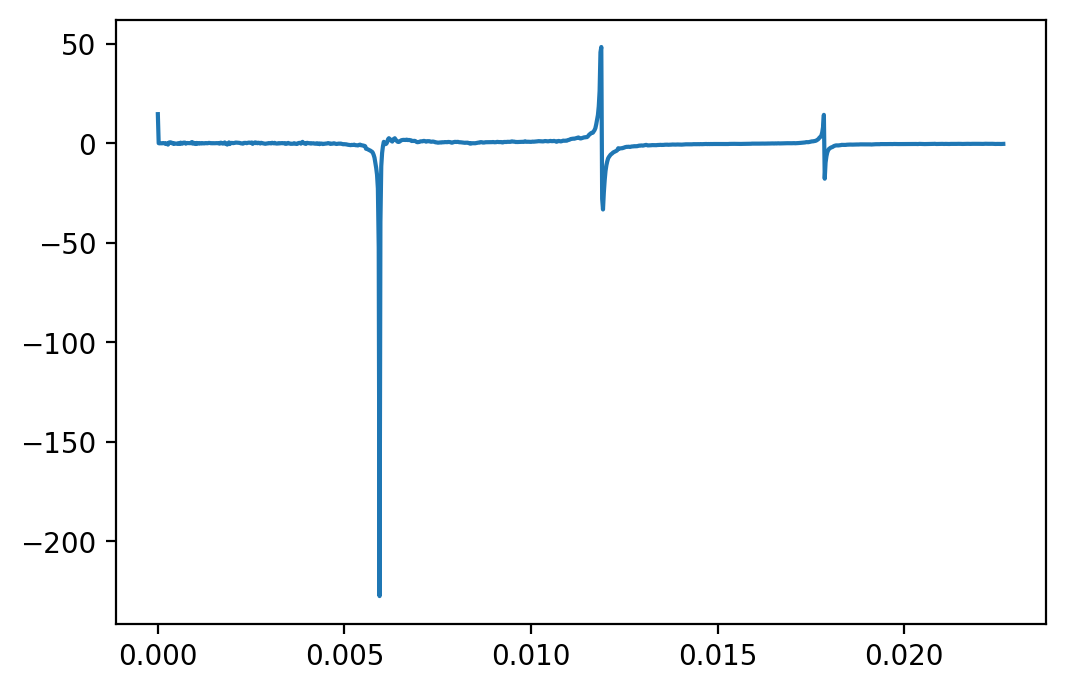

In [438]:
import warnings
warnings.filterwarnings('ignore')

data_hat = np.fft.fft(data)
plt.plot(time[:1000], data_hat[:1000])
plt.show()

In [439]:
np.random.seed(0) # produce the same random numbers every time the code is run (optional)
noisy_data = data + 0.005 * np.random.randn(len(data)) # perturb data with random noise

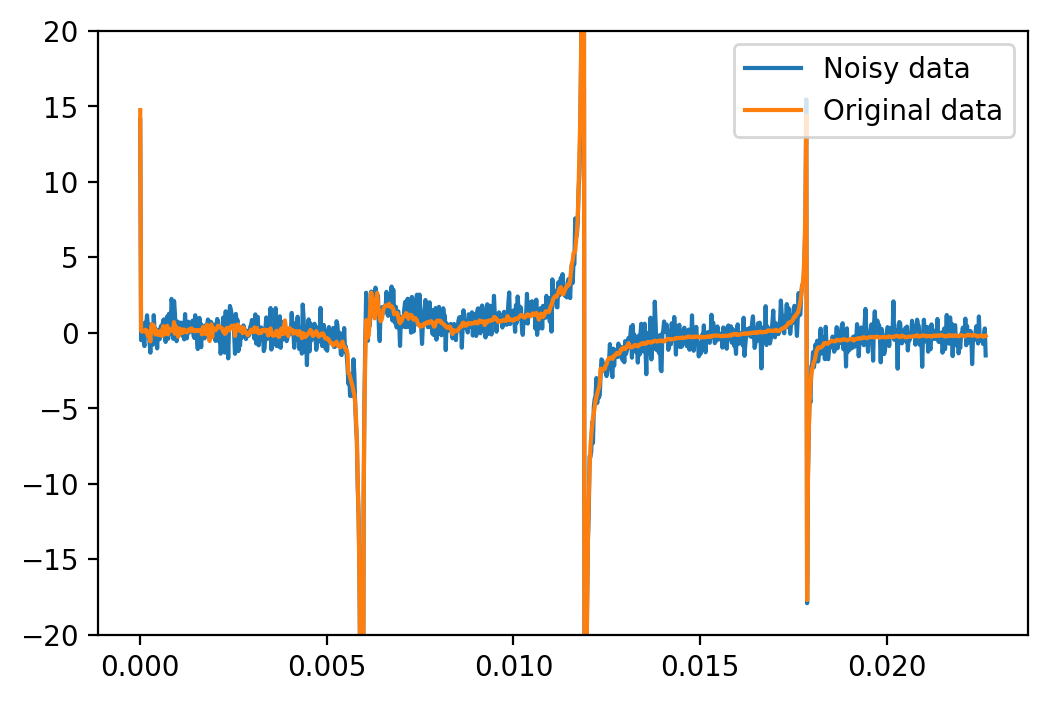

In [440]:
noisy_data_hat = np.fft.fft(noisy_data)
plt.plot(time[:1000], noisy_data_hat[:1000], label="Noisy data")
plt.plot(time[:1000], data_hat[:1000], label="Original data")
plt.legend(loc="best")
plt.ylim(-20, 20)
plt.show()

Now, we choose a cutoff value of $\delta = 3$. For any entry in the noisy DFT with magnitude greater than $\delta$, we zero this entry. We then use the inverse DFT to produce a denoised signal. 

In [441]:
# zero small entries
thresh = 3.0
denoised_dft = [0 if x < thresh else x for x in noisy_data_hat]
# calculate inverse DFT to go back to the time domain
denoised_data = np.fft.ifft(denoised_dft)

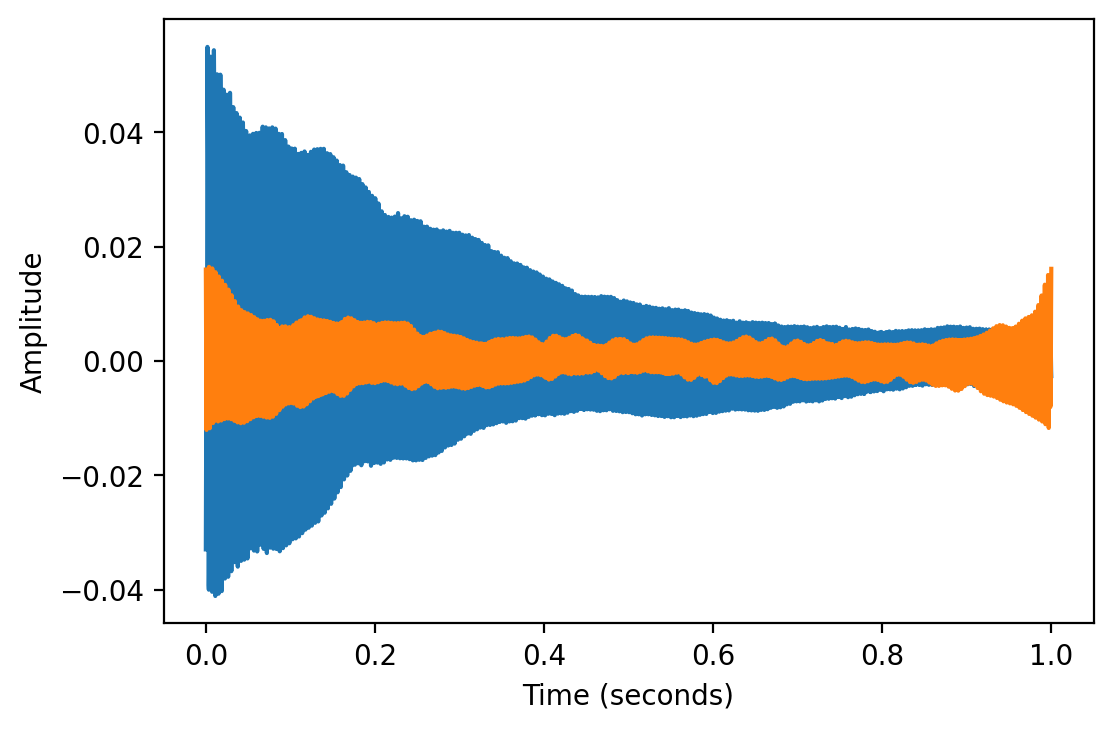

In [442]:
plt.plot(time, data, label="Original data")
plt.plot(time, denoised_data, label="Denoised data")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [443]:
import scipy.io.wavfile as wavfile
samplerate = 44100 # samples per second in the audio
# Note: after an inverse DFT you usually get complex values with very small imaginary parts
# (of size machine epsilon), which we need to remove before saving.
wavfile.write('original_audio.wav', samplerate, np.real(data))
wavfile.write('denoised_audio.wav', samplerate, np.real(denoised_data))

## Solving ODEs

### Question 4
Modify the above code to implement our ODE ($f$ and $u_0$) for time horizon T = 100
days. Then, implement the one-step methods: explicit Euler, Heun’s method and the classical 4th order Runge-Kutta scheme (RK4). For $n = 200$, plot your three computed solutions against the true solution $u(t)$. Interpret the solution to this ODE in terms of the application setting (infectious disease).

In [451]:
# RHS of the ODE
def f(t, u):
    return 0.2*u*(1-u)

# One-step method
def explicit_euler(t, u, h):
    return u + h*f(t, u)

def heun_method(t, u, h):
    e_euler = u + h*f(u, t)
    return u + (0.5*h)*f(t, u) + (0.5*h)*f(t+h, u+h*f(t, u))

def runge_kutta(t, u, h):
    k_1 = f(t, u)
    k_2 = f(t + 0.5*h, u + 0.5*h*k_1)
    k_3 = f(t + 0.5*h, u + 0.5*h*k_2)
    k_4 = f(t + h, u + h*k_3)
    return u + h*((1/6)*k_1 + (2/6)*k_2 + (2/6)*k_3 + (1/6)*k_4)

# define ODE conditions
P, c = 10000, 0.2
u0 = 1/P # initial condition
T = 100.0 # end time
n = 400 # use n+1 equally spaced time steps
ts = np.linspace(0, T, n+1) # vector of timesteps, tk = ts[k]
h = T / n # gap between timesteps

# define the arrays for our solutions
euler = np.zeros((n+1,)) # create an empty vector for our solution
euler[0] = u0 # set initial condition
heun = np.zeros((n+1,))
heun[0] = u0
rk = np.zeros((n+1,))
rk[0] = u0

# Run the one-step method
for k in range(n):
    euler[k+1] = explicit_euler(ts[k], euler[k], h)
    heun[k+1] = heun_method(ts[k], heun[k], h)
    rk[k+1] = runge_kutta(ts[k], rk[k], h)

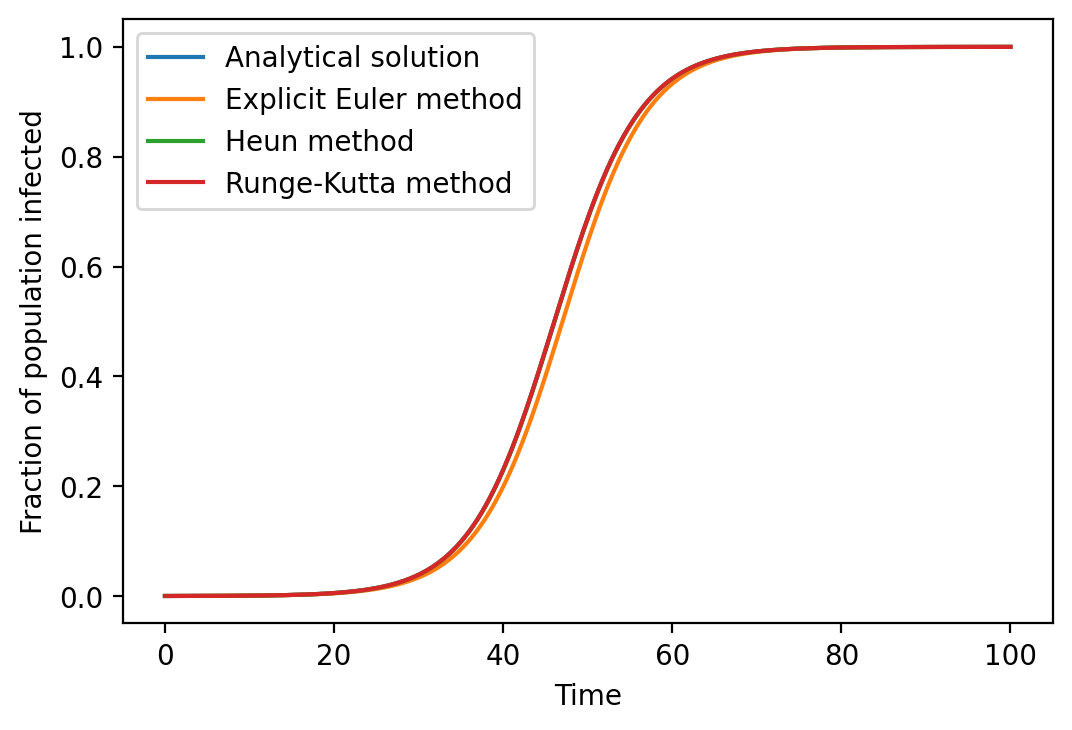

In [461]:
# define analytical solution
def analytical_solution(t):
    return 1 / (1 + (P-1)*np.exp(-c*t))
actual_u = analytical_solution(ts)

# plot the solutions and compare
plt.plot(ts, actual_u, label="Analytical solution")
plt.plot(ts, euler, label="Explicit Euler method")
plt.plot(ts, heun, label="Heun method", linestyle='-')
plt.plot(ts, rk, label="Runge-Kutta method", linestyle='-')
plt.xlabel("Time")
plt.ylabel("Fraction of population infected")
plt.legend(loc="best")
plt.show()

### Question 5
For $n = 50, 100, 200, 400, 800, 1600$ and each of the three one-step methods, produce a
table similar to slide 41 of the ODE lectures, computing the maximum absolute error $|u_k − u(t_k)|$ at any time step $t_k$ for each method. From your table, determine what order of convergence you are seeing in each method and compare this to the theory in lectures. 

In [453]:
def solutions(n):
    # define ODE conditions
    P, c = 10000, 0.2
    u0 = 1/P # initial condition
    T = 100.0 # end time
    ts = np.linspace(0, T, n+1) # vector of timesteps, tk = ts[k]
    h = T / n # gap between timesteps

    # define the arrays for our solutions
    euler = np.zeros((n+1,)) # create an empty vector for our solution
    euler[0] = u0 # set initial condition
    heun = np.zeros((n+1,))
    heun[0] = u0
    rk = np.zeros((n+1,))
    rk[0] = u0

    # Run the one-step method
    for k in range(n):
        euler[k+1] = explicit_euler(ts[k], euler[k], h)
        heun[k+1] = heun_method(ts[k], heun[k], h)
        rk[k+1] = runge_kutta(ts[k], rk[k], h)

    # analytical solution
    actual_u = analytical_solution(ts)
    
    return actual_u, [euler, heun, rk], h

In [454]:
# our three solutions are defined in the following arrays
ns = [50, 100, 200, 400, 800, 1600]
hs, error_arrays = [], []
for j in range(len(ns)):
    actual_u, sols, h = solutions(ns[j])
    hs.append(h)
    max_errors = []
    for sol in sols:
        differences = np.absolute(np.subtract(actual_u, sol))
        max_errors.append(max(differences))
    error_arrays.append(max_errors)

In [455]:
eulers, heuns, rks = [], [], []
for array in error_arrays:
    eulers.append(array[0])
    heuns.append(array[1])
    rks.append(array[2])

In [456]:
import pandas as pd

df_dict = {'h': hs, 'Euler': eulers, 'Heun': heuns, 'RK4': rks}
max_errors = pd.DataFrame(df_dict)
max_errors

,h,Euler,Heun,RK4
0,2.0000,0.351179,0.039273,2.786116e-04
1,1.0000,0.187613,0.011200,2.032359e-05
2,0.5000,0.096127,0.003000,1.373054e-06
3,0.2500,0.048526,0.000776,8.924093e-08
4,0.1250,0.024363,0.000197,5.688315e-09
5,0.0625,0.012204,0.000050,3.590143e-10


### Question 6
Use `solve_ivp` with RK45 to solve the original and our new ODE and plot the two solutions.
How many people are healthy after 100 days under the two scenarios? How many extra people would be
healthy at day 100 if we started vaccinating on day $t = 0$ rather than day $t = 5$?

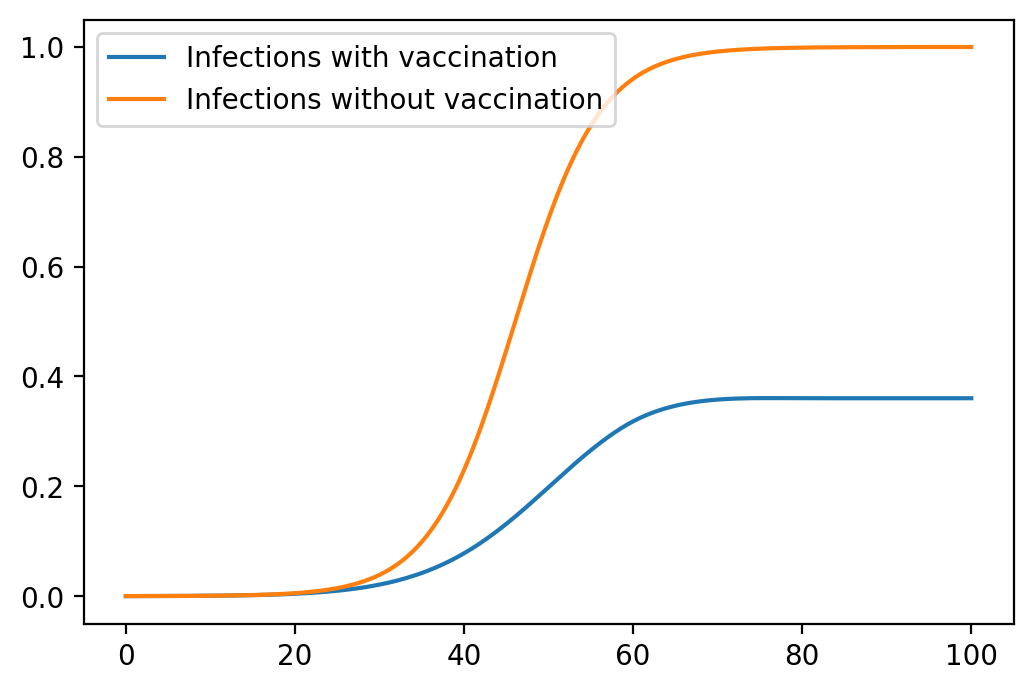

In [462]:
import scipy.integrate as integrate

# RHS of the ODE
def f(t, u):
    return c*u*max(1-u-0.01*max(t-5,0), 0)

# define ODE conditions
P, c = 10000, 0.2
u0 = np.array([1/P]) # initial condition (must be a NumPy array)
T = 100.0 # end time
ts = np.linspace(0, T, n+1) # vector of timesteps, tk = ts[k]

# define analytical solution
def analytical_solution(t):
    return 1 / (1 + (P-1)*np.exp(-c*t))
actual_u = analytical_solution(ts)

sol = integrate.solve_ivp(f, [0, T], u0, method='RK45', t_eval=ts)
# sol.t has the time steps where the solution is evaluated
# sol.y[0,:] has the value of the solution at times sol.t

plt.plot(sol.t, sol.y[0,:], label="Infections with vaccination")
plt.plot(ts, actual_u, label="Infections without vaccination")
plt.legend(loc="best")
plt.show()

### Question 7
Solve this system of ODEs using the explicit Euler method, $u_{k+1} = u_k + \Delta t f(t, u_k)$ for some time discretisation $\Delta t$. Using data $a = b = 0, c = 1$ and $f(x) = \sin(\pi x)$, plus spatial discretisation $n = 10$ and time step $\Delta t = 0.5/n^2$, plot the solution $u(t, x)$ versus $x$ for $t = 0, 0.1, 0.2, ..., 0.5$.

First, we set up our problem using the given information, and discretise the spatial dimension.

In [427]:
# Physical parameters
c = 1                           # Heat transfer coefficient
lx = 1.                         # Size of computational domain

# Grid parameters
nx = 10                         # number of grid points 
dx = lx / (nx)                # grid spacing
x = np.linspace(0., lx, nx)     # coordinates of grid points

# Time parameters
ti = 0.                         # initial time
tf = 1.                         # final time
dt = 0.5/nx**2                  # time step
nt = int((tf-ti) / dt)          # number of time steps

# initial condition
u_0 = np.sin(np.pi*x)

In [428]:
def rhs_centered(u, dx, c):
    nx = u.shape[0]
    f = np.empty(nx)
    f[1:-1] = c/dx**2 * (u[:-2] - 2*u[1:-1] + u[2:])
    f[0] = 0.
    f[-1] = 0.
    return f

def euler_step(u, f, dt, *args):  
    u_new = u + dt * f(u, *args)
    return u_new

In [429]:
u = np.empty((nt+1, nx))
u[0] = u_0.copy()

for i in range(nt):
    u[i+1] = euler_step(u[i], rhs_centered, dt, dx, c)

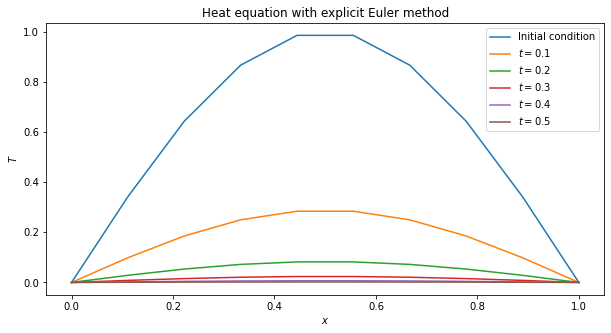

In [430]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, u[0], label='Initial condition')
ax.plot(x, u[int(0.1/dt)], label='$t=0.1$')
ax.plot(x, u[int(0.2/dt)], label='$t=0.2$')
ax.plot(x, u[int(0.3/dt)], label='$t=0.3$')
ax.plot(x, u[int(0.4/dt)], label='$t=0.4$')
ax.plot(x, u[int(0.5/dt)], label='$t=0.5$')

ax.set_xlabel('$x$')
ax.set_ylabel('$T$')
ax.set_title('Heat equation with explicit Euler method')
ax.legend();

### Question 8
With this choice of $f(x)$, plot the solution after 500 iterations for $\Delta t = \alpha/n^2$ where $\alpha \in \{0.48, 0.5, 0.52\}$ and $n = 100$. What do you observe?

First, we combine the parameter instantiation along with the Euler steps and plotting into a single function which takes an argument `alpha` for the time discretisation:

In [403]:
import warnings
warnings.filterwarnings('ignore')

def discretise_solve(alpha):
    # spatial discretisation
    nx = 100                        # number of grid points 
    dx = 1 / (nx)                   # grid spacing
    x = np.linspace(0., 1, nx)      # coordinates of grid points
    
    # time discretisation
    ti = 0.                         # initial time
    tf = 1.                         # final time
    dt = alpha/nx**2                # time step
    nt = int((tf-ti) / dt)          # number of time steps
    # initial conditions
    T0 = 0.5-x                      # initial condition
    source = 0*x                    # heat source term
    
    T = np.empty((nt+1, nx))
    T[0] = T0.copy()

    for i in range(nt):
        T[i+1] = euler_step(T[i], rhs_centered, dt, dx, 1, source)
        
    # plot the solution at several times
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x, T[0], label='Initial condition')
    ax.plot(x, T[500], label=f'alpha={alpha}')

    ax.set_xlabel('$x$')
    ax.set_ylabel("Solution $u(t, x)$")
    ax.legend();

Now, we plot for different values of $\alpha$. When `alpha=0.52`, we get an extremely erratic solution, which is nowhere near the stable solution $u(x,t)=0.5-x$.

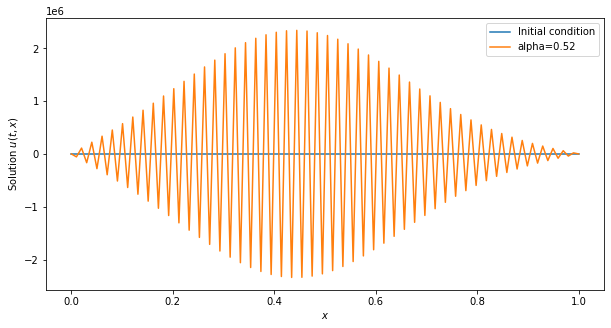

In [395]:
discretise_solve(0.52)

However, we don't get the same unstable behaviour when using smaller values of alpha:

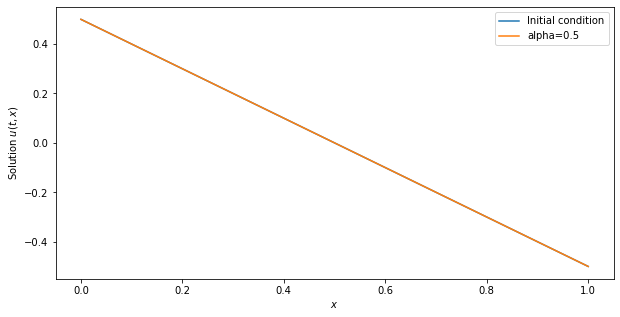

In [404]:
discretise_solve(0.50)

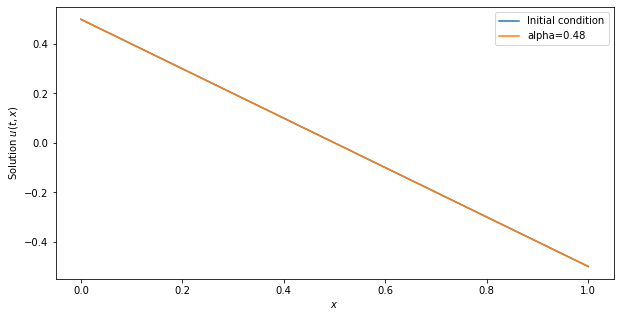

In [405]:
discretise_solve(0.48)

To see why this is the case, note that our requirement for stability is given by $\Delta t \leq \Delta x^2/2c$. If $n=100$, we have that $\Delta x^2/2c$ is given by:

In [406]:
cond = (1/100)**2/(2*1)
cond

5e-05

Additionally, our time discretisation step-size is given by:

In [407]:
alpha = 0.5
dt = alpha/100**2
dt

5e-05

So, if we increase $\alpha$ (even just marginally), we get that $\Delta t > \Delta x^2/2c$:

In [408]:
alpha = 0.52
dt = alpha/100**2
dt <= cond

False